### Importation des modules et packages

In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import requests 
import urllib
import bs4
import pandas as pd
from urllib import request
import re
from tqdm import tqdm
from scipy import *
!pip install pandas_profiling 
!pip install ipywidgets
from pandas_profiling import ProfileReport

# Récupération des données 

### WebScrapping des noms de films sur Wikipédia 

On stocke tous les noms des films présents sur cette page dans une liste que l'on appelle Liste_films.
On modifie le format de certains titre : ' XXX (1967)' devient ' XXX '
Finalement, on récupère la longueur de la liste : elle est de ≈ 1500. 

In [2]:
!pip install lxml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 17.4 MB/s eta 0:00:0000:0100:01


In [3]:
response = requests.get(
	url="https://en.wikipedia.org/wiki/List_of_years_in_film",
)
soup = bs4.BeautifulSoup(response.content, 'html.parser')

title = soup.find(id="firstHeading")
print(title.string)

List of years in film


In [4]:
all_names= soup.findAll("i")
L=[]
for link in all_names :
    t=link.findAll('a')
    if len(t)!=0:
        r=t[0]['title']
        L.append(r)
# print(L)

In [5]:
# on enlève les précisions entre parenthèses 

Liste_films= []
for i in L: 
    Liste_films.append(re.sub("\(.*?\)","()",i).replace("()",""))
#print(L2)
len(Liste_films)

1537

### Utilisation d'une API pour récupérer l'identifiant des films à partir de leur titre

On utilise l'API: The Movie Database API (TMDB API) pour laquelle j'ai du faire une demande de clé : api_key
On place ces identifiants dans une liste index.

#### CAS PARTICULIER : on fixe le nom du film

In [6]:
# on va utiliser une première requête d'API pour accéder aux ID des films scrappés sur Wikipédia
api_key='28c6630049f5d468217e4f34963c03a6' #clé de l'API 
nom_du_film='Earth '

url_api=f"https://api.themoviedb.org/3/search/movie?api_key={api_key}&query={nom_du_film}" 
#requête pour trouver les infos ayant le nom_du_film en title 
req = requests.get(url_api)
wb = req.json()


# on récupère tous les indexs des films en question 
index=[]
for film in range(len(wb['results'])):
    index.append(wb['results'][film]['id'])
index  

[811367,
 82700,
 748853,
 5491,
 443297,
 10946,
 55420,
 197624,
 347111,
 68179,
 13363,
 464593,
 88751,
 11569,
 31642,
 641370,
 339,
 246400,
 238603,
 831]

In [7]:
api_key='28c6630049f5d468217e4f34963c03a6' #clé de l'API 

def get_id(nom):
    url_api=f"https://api.themoviedb.org/3/search/movie?api_key={api_key}&query={nom}" 
    #requête pour trouver les infos ayant le nom_du_film en title 
    req = requests.get(url_api)
    wb = req.json()


    # on récupère tous les indexs des films en question 
    index=[]
    for film in range(len(wb['results'])):
        index.append(wb['results'][film]['id'])
    return(index)



### Récupération du détail des données grâce à une autre API 

Toujours sur TMDB API, on utilise cette fois l'id du film pour accéder à un grand nombre de données sur ce film : get detail. 
Pour cela on fait appel à la fonction précédente qui nous donnait les id correspondant au titre du film. 
On ajuste le format des données pour que les tailles des éléments nous permettent de convertir le dictionnaire
en DataFrame pandas. 

In [8]:
def df_avec_id(id):
    id_film= id
    url_new_api = f"https://api.themoviedb.org/3/movie/{id_film}?api_key={api_key}&language=en-US"
    req_new = requests.get(url_new_api)
    wb_new = req_new.json()
    
    
    #ajustement des données 
    if wb_new['belongs_to_collection']!=None: 
        wb_new['belongs_to_collection']=wb_new['belongs_to_collection']['name']
        
    wb_new['genres']=' , '.join([x['name'] for x in wb_new['genres']]) #on ne sélectionne que le nom des genres 
    wb_new['production_companies']=' , '.join([x['name'] for x in wb_new['production_companies']]) #on ne sélectionne que les noms (même pas les pays)
    wb_new['production_countries']=' , '.join([x['name'] for x in wb_new['production_countries']])
    wb_new['spoken_languages']=' , '.join([x['name'] for x in wb_new['spoken_languages']])
    
    df=pd.DataFrame(wb_new, index=[wb_new['id']])  #j'ai mis l'ID en index mais on peut aussi indexer à partie de 0
    # pour cela, on met index=[0]
    
    return (df)

### Généralisation et concaténation

On utilise les deux fonctions précédentes pour créer notre DataFrame all. 
On parcourt la liste des titres puis la liste des id pour chacun des films. 
On a donc une double-boucle for, ce qui s'avère couteux mais qui fonctionne au bout d'1h30. 

Un axe d'amélioration serait de réduire le temps pour cette collecte de données. 

In [9]:
def concat_all(liste):
    Liste_fail=[]
    
    DF_ALL=pd.DataFrame()
    for nom in tqdm(liste):
        #print(nom)
        ind=get_id(nom)
        for i in ind:
            try:
                df_2=df_avec_id(i)
                #print(df_2.budget)
                if df_2['budget'].all()>0:
                    DF_ALL=pd.concat([DF_ALL,df_2],axis=0)
                    
            except ValueError:
                Liste_fail.append([nom,i])
    print(Liste_fail)
    return DF_ALL

In [10]:
def concat_all_2(liste):
    Liste_fail=[]
    DF_ALL=pd.DataFrame()
    for nom in tqdm(liste):
        #print(nom)
        ind=get_id(nom)
        f_vect(ind)
    print(Liste_fail)
    return DF_ALL

In [11]:
def fonction_int(id):
    try:
                df_2=df_avec_id(id)
                #print(df_2.budget)
                if df_2['budget'].all()>0:
                    return(pd.DataFrame())
                    
    except ValueError:
                Liste_fail.append(id)
            

f_vect = np.vectorize(fonction_int)

In [12]:
l=Liste_films
a=concat_all(l)

100%|██████████| 1537/1537 [38:02<00:00,  1.49s/it] 

[]


In [14]:
a.head(5)

adult                     backdrop_path  belongs_to_collection  \
603     False  /l4QHerTSbMI7qgvasqxP36pqjN6.jpg  The Matrix Collection   
624860  False  /eNI7PtK6DEYgZmHWP9gQNuff8pv.jpg  The Matrix Collection   
604     False  /pxK1iK6anS6erGg4QePmMKbB1E7.jpg  The Matrix Collection   
605     False  /533xAMhhVyjTy8hwMUFEt5TuDfR.jpg  The Matrix Collection   
13764   False  /xLDSKsyAGFFCNYDmNynEOsms5jp.jpg                   None   

           budget                                           genres  \
603      63000000                         Action , Science Fiction   
624860  190000000             Science Fiction , Action , Adventure   
604     150000000  Adventure , Action , Thriller , Science Fiction   
605     150000000  Adventure , Action , Thriller , Science Fiction   
13764    50000000                     Family , Fantasy , Adventure   

                                homepage      id     imdb_id  \
603     http://www.warnerbros.com/matrix     603   tt0133093   
624860   https://www.whatisthematrix.com  624860  tt10838180   
604                                          604   tt0234215   
605                                          605   tt0242653   
13764                                      13764   tt0089961   

       original_language            original_title  ... release_date  \
603                   en                The Matrix  ...   1999-03-30   
624860                en  The Matrix Resurrections  ...   2021-12-16   
604                   en       The Matrix Reloaded  ...   2003-05-15   
605                   en    The Matrix Revolutions  ...   2003-11-05   
13764                 en    Santa Claus: The Movie  ...   1985-10-29   

          revenue runtime    spoken_languages    status  \
603     463517383     136             English  Released   
624860  156497322     147             English  Released   
604     738599701     138             English  Released   
605     424988211     129  English , Français  Released   
13764    23717291     108             English  Released   

                                            tagline                     title  \
603                      Welcome to the Real World.                The Matrix   
624860                        Return to the source.  The Matrix Resurrections   
604                                 Free your mind.       The Matrix Reloaded   
605     Everything that has a beginning has an end.    The Matrix Revolutions   
13764                   Guess who's coming to town!    Santa Claus: The Movie   

        video vote_average vote_count  
603     False        8.200      22408  
624860  False        6.600       4322  
604     False        7.025       9435  
605     False        6.700       8481  
13764   False        6.300        205  

[5 rows x 25 columns]

## On va exporter ce fichier en csv pour ne pas à recharger à chaque fois car le chargement est chronophage( 30min).

In [9]:
# on enregistre le fichier 
a.to_csv('Projet_films.csv',index=False) 

In [8]:
# on vient charger le fichier 
df=pd.read_csv('ProjetFilms.csv')

In [6]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Résolution des problèmes du dataset

Genres

On va créer pour chaque genre une variable "nom du genre" qui vaudra 1 si le film appartient à ce genre et 0 sinon. Cela permettra de résoudre le pb de la multiappartenance

Nationalité

On fait de même qu'avec les genres

Saga

Créer une variable 1 ou 0

# Visualisation des données

Regardons si l'ont peut trouver des liens entre nos données et les revenus générés par les films sélectionnés

Nous utilisons "xlim" et "ylim" pour écarter quelques valeurs extrêmes et avoir une vision plus claire de la plus grande partie de nos données

Text(0, 0.5, 'Revenus générés par les films(en milliards de dollars)')

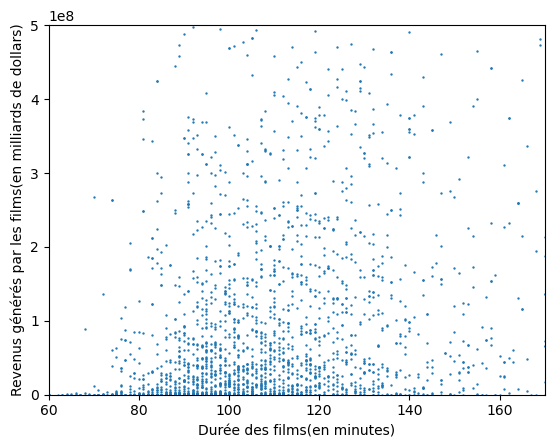

In [51]:
plt.scatter(a["runtime"], a["revenue"], s = 2, marker = ".")
plt.xlim([60, 170])
plt.ylim([0,0.5*10**9])
plt.xlabel("Durée des films(en minutes)")
plt.ylabel("Revenus générés par les films(en milliards de dollars)")

Text(0, 0.5, 'Revenus générés par les films(en milliards de dollars)')

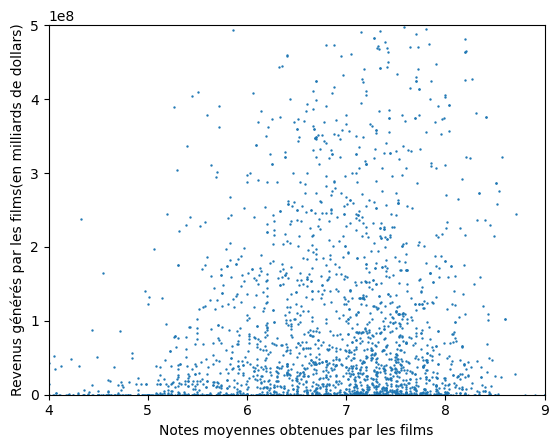

In [52]:
plt.scatter(a["vote_average"], a["revenue"], s = 2, marker = ".")
plt.xlim([4,9])
plt.ylim([0,0.5*10**9])
plt.xlabel("Notes moyennes obtenues par les films")
plt.ylabel("Revenus générés par les films(en milliards de dollars)")

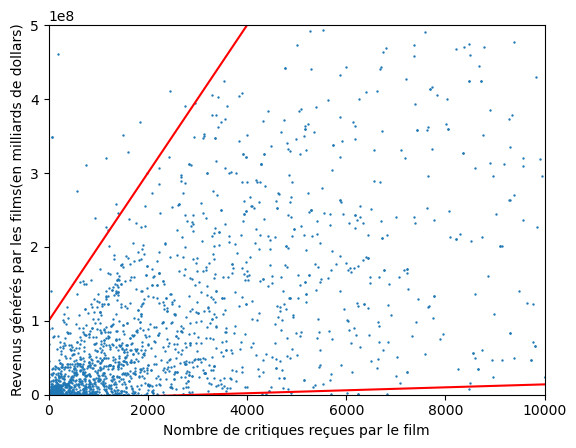

In [79]:
plt.scatter(a["vote_count"], a["revenue"], s = 2, marker = ".")
plt.xlim([0,1*10**4])
plt.ylim([0,0.5*10**9])
plt.xlabel("Nombre de critiques reçues par le film")
plt.ylabel("Revenus générés par les films(en milliards de dollars)")
def f(x):
    return (1*10**5)*x + 1*10**8
plt.plot([f(x) for x in range(10000)], color = "red")
def g(x):
    return 2000*x - 6*10**6
plt.plot([g(x) for x in range(10000)], color = "red")

Text(0, 0.5, 'Revenus générés par les films(en milliards de dollars)')

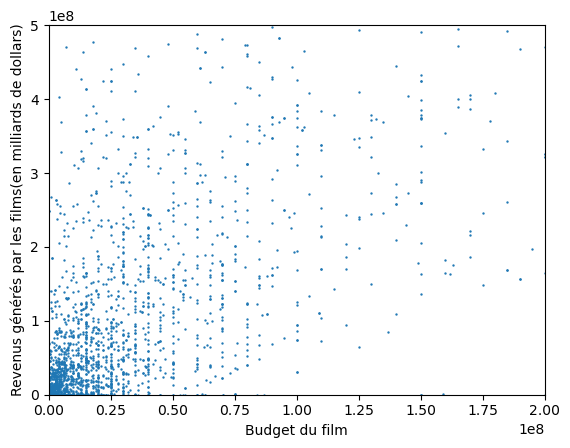

In [84]:
plt.scatter(a["budget"], a["revenue"], s = 2, marker = ".")
plt.xlim([0,2*10**8])
plt.ylim([0,0.5*10**9])
plt.xlabel("Budget du film")
plt.ylabel("Revenus générés par les films(en milliards de dollars)")

## Modélisation 

### Preprocessing 
 
On va chercher les variables utiles pour notre modèle de prédiction. 
D'autre part, on va travailler sur les variables (genres, production countries...) de manière à rendre ces dernières exploitables. Pour cela, on va créer pour chaque genre une variable "Nom_du_Genre" ("Action" par exemple) qui vaudra 1 si le film appartient à ce genre et 0 sinon.

D'après le Profile Report du début, on observe que tous les films sont classés "Adult", cette variable n'a donc ici que peu d'intérêt. 
On fait le choix de ne pas prendre en compte les variables suivantes pour notre modèle:
- adult 
- backdrop_path
- homepage
- id 
- imdb_id
- original title
- overview
- poster_path 

In [11]:
df.columns

Index(['adult', 'backdrop_path', 'belongs_to_collection', 'budget', 'genres',
       'homepage', 'id', 'imdb_id', 'original_language', 'original_title',
       'overview', 'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [12]:
df_bis= df[['belongs_to_collection','budget','genres','original_language','production_countries','popularity','production_companies','release_date','revenue','runtime','spoken_languages','status']]

In [15]:
#on ne garde que les films qui sont sortis 
df_bis=df_bis[df_bis.status=='Released']

In [29]:
# on change le type des dates maintenant, il s'agit bien de datetime
df_bis.release_date=pd.to_datetime(df_bis.release_date, format='%Y-%m-%d', errors = 'ignore')

In [46]:
df_bis= df_bis[df_bis.runtime!=0]

In [54]:
df_bis['release_year']=df_bis['release_date'].dt.year 
df_bis['release_month']=df_bis['release_date'].dt.month 
df_bis['release_day']=df_bis['release_date'].dt.day 

/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_1981/3337846351.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bis['release_year']=df_bis['release_date'].dt.year
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_1981/3337846351.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bis['release_month']=df_bis['release_date'].dt.month
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_1981/3337846351.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

## On enlève les warnings causés pas le .iloc 

In [55]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

# On travaille la variable Genre

In [56]:
Liste_genres= df_bis['genres'].unique()
p = re.compile(r'\W+')

Liste_finale=[]

for i in Liste_genres : 
    #print(str(i))
    sous_liste= p.split(str(i))
    for j in sous_liste :
        Liste_finale.append(j)
        
Liste_finale = np.unique(Liste_finale)     
Liste_finale

array(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Fiction', 'History',
       'Horror', 'Movie', 'Music', 'Mystery', 'Romance', 'Science', 'TV',
       'Thriller', 'War', 'Western', 'nan'], dtype='<U11')

In [57]:
for genre in Liste_finale:
    df_bis[genre]= df_bis['genres'].str.contains(genre, case=False).astype(bool).astype(int)
df_bis

/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_1981/3385623746.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bis[genre]= df_bis['genres'].str.contains(genre, case=False).astype(bool).astype(int)


belongs_to_collection     budget  \
0      The Matrix Collection  190000000   
1      The Matrix Collection   63000000   
2      The Matrix Collection  150000000   
3      The Matrix Collection  150000000   
4                        NaN   50000000   
...                      ...        ...   
2848        X-Men Collection  250000000   
2849  The X Files Collection   66000000   
2850                     NaN   18000000   
2851          F/X Collection   10000000   
2852                     NaN   15600000   

                                               genres original_language  \
0                Science Fiction , Action , Adventure                en   
1                            Action , Science Fiction                en   
2     Adventure , Action , Thriller , Science Fiction                en   
3     Adventure , Action , Thriller , Science Fiction                en   
4                        Family , Fantasy , Adventure                en   
...                                               ...               ...   
2848             Action , Adventure , Science Fiction                en   
2849             Mystery , Science Fiction , Thriller                en   
2850                                   Drama , Comedy                en   
2851                                Action , Thriller                en   
2852                                   Comedy , Drama                en   

                                   production_countries  popularity  \
0                              United States of America     213.259   
1                              United States of America      77.938   
2                              United States of America      40.939   
3                              United States of America      37.752   
4                              United States of America      11.490   
...                                                 ...         ...   
2848                           United States of America      99.569   
2849                  Canada , United States of America      21.736   
2850                           United States of America      13.656   
2851                           United States of America      13.531   
2852  United States of America , Germany , United Ki...      41.282   

                                   production_companies release_date  \
0     Village Roadshow Pictures , Warner Bros. Pictu...   2021-12-16   
1     Village Roadshow Pictures , Warner Bros. Pictu...   1999-03-30   
2     Village Roadshow Pictures , NPV Entertainment ...   2003-05-15   
3     Village Roadshow Pictures , NPV Entertainment ...   2003-11-05   
4     TriStar Pictures , Calash Corporation , GGG , ...   1985-10-29   
...                                                 ...          ...   
2848  20th Century Fox , The Donners' Company , Bad ...   2014-05-15   
2849        20th Century Fox , Ten Thirteen Productions   1998-06-19   
2850  20th Century Fox , Amercent Films , American E...   1987-04-17   
2851                                     Orion Pictures   1986-02-07   
2852  ARTE , BBC Films , Film i Väst , SVT , Coprodu...   2022-09-23   

        revenue  runtime  ... Movie Music  Mystery  Romance  Science  TV  \
0     156497322      148  ...     0     0        0        0        1   0   
1     463517383      136  ...     0     0        0        0        1   0   
2     738599701      138  ...     0     0        0        0        1   0   
3     424988211      129  ...     0     0        0        0        1   0   
4      23717291      108  ...     0     0        0        0        0   0   
...         ...      ...  ...   ...   ...      ...      ...      ...  ..   
2848  747862775      132  ...     0     0        0        0        1   0   
2849  189198313      121  ...     0     0        1        0        1   0   
2850   18532286      108  ...     0     0        0        0        0   0   
2851   20603715      109  ...     0     0        0        0        0   0   
2852    2600000      147  ...     0

# On travaille la variable production_countries

In [58]:
Liste_pays_prod= df_bis['production_countries'].unique()
Liste_finale=[]

for i in Liste_pays_prod : 
    #print(str(i))
    sous_liste= re.split(' ; | , ', str(i))
    for j in sous_liste :
        Liste_finale.append(j)
        
Liste_finale = np.unique(Liste_finale)     
Liste_finale

array(['Algeria', 'Argentina', 'Australia', 'Austria', 'Bahamas',
       'Belgium', 'Belize', 'Botswana', 'Brazil', 'Bulgaria', 'Canada',
       'China', 'Colombia', 'Cuba', 'Cyprus', 'Czech Republic', 'Denmark',
       'Dominican Republic', 'Egypt', 'Estonia', 'Finland', 'France',
       'Germany', 'Greece', 'Hong Kong', 'Hungary', 'India', 'Indonesia',
       'Iran', 'Ireland', 'Israel', 'Italy', 'Japan', 'Lebanon',
       'Libyan Arab Jamahiriya', 'Lithuania', 'Luxembourg', 'Malta',
       'Mexico', 'Montenegro', 'Morocco', 'Netherlands', 'New Zealand',
       'Norway', 'Peru', 'Philippines', 'Poland', 'Portugal',
       'Puerto Rico', 'Qatar', 'Romania', 'Russia', 'Rwanda', 'Serbia',
       'Slovenia', 'South Africa', 'South Korea', 'Soviet Union', 'Spain',
       'Sweden', 'Switzerland', 'Taiwan', 'Thailand', 'Turkey', 'Ukraine',
       'United Arab Emirates', 'United Kingdom',
       'United States of America', 'Vietnam', 'nan'], dtype='<U24')

In [60]:
for pays in Liste_finale:
    df_bis[pays]= df_bis['production_countries'].str.contains(pays, case=False).astype(bool).astype(int)
df_bis

/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_1981/567759430.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bis[pays]= df_bis['production_countries'].str.contains(pays, case=False).astype(bool).astype(int)


belongs_to_collection     budget  \
0      The Matrix Collection  190000000   
1      The Matrix Collection   63000000   
2      The Matrix Collection  150000000   
3      The Matrix Collection  150000000   
4                        NaN   50000000   
...                      ...        ...   
2848        X-Men Collection  250000000   
2849  The X Files Collection   66000000   
2850                     NaN   18000000   
2851          F/X Collection   10000000   
2852                     NaN   15600000   

                                               genres original_language  \
0                Science Fiction , Action , Adventure                en   
1                            Action , Science Fiction                en   
2     Adventure , Action , Thriller , Science Fiction                en   
3     Adventure , Action , Thriller , Science Fiction                en   
4                        Family , Fantasy , Adventure                en   
...                                               ...               ...   
2848             Action , Adventure , Science Fiction                en   
2849             Mystery , Science Fiction , Thriller                en   
2850                                   Drama , Comedy                en   
2851                                Action , Thriller                en   
2852                                   Comedy , Drama                en   

                                   production_countries  popularity  \
0                              United States of America     213.259   
1                              United States of America      77.938   
2                              United States of America      40.939   
3                              United States of America      37.752   
4                              United States of America      11.490   
...                                                 ...         ...   
2848                           United States of America      99.569   
2849                  Canada , United States of America      21.736   
2850                           United States of America      13.656   
2851                           United States of America      13.531   
2852  United States of America , Germany , United Ki...      41.282   

                                   production_companies release_date  \
0     Village Roadshow Pictures , Warner Bros. Pictu...   2021-12-16   
1     Village Roadshow Pictures , Warner Bros. Pictu...   1999-03-30   
2     Village Roadshow Pictures , NPV Entertainment ...   2003-05-15   
3     Village Roadshow Pictures , NPV Entertainment ...   2003-11-05   
4     TriStar Pictures , Calash Corporation , GGG , ...   1985-10-29   
...                                                 ...          ...   
2848  20th Century Fox , The Donners' Company , Bad ...   2014-05-15   
2849        20th Century Fox , Ten Thirteen Productions   1998-06-19   
2850  20th Century Fox , Amercent Films , American E...   1987-04-17   
2851                                     Orion Pictures   1986-02-07   
2852  ARTE , BBC Films , Film i Väst , SVT , Coprodu...   2022-09-23   

        revenue  runtime  ... Sweden Switzerland  Taiwan  Thailand  Turkey  \
0     156497322      148  ...      0           0       0         0       0   
1     463517383      136  ...      0           0       0         0       0   
2     738599701      138  ...      0           0       0         0       0   
3     424988211      129  ...      0           0       0         0       0   
4      23717291      108  ...      0           0       0         0       0   
...         ...      ...  ...    ...         ...     ...       ...     ...   
2848  747862775      132  ...      0           0       0         0       0   
2849  189198313      121  ...      0           0       0         0       0   
2850   18532286      108  ...      0           0       0         0       0   
2851   20603715      109  ...      0           0       0         0       0   
2852    26000

In [63]:
df_bis

belongs_to_collection     budget  \
0      The Matrix Collection  190000000   
1      The Matrix Collection   63000000   
2      The Matrix Collection  150000000   
3      The Matrix Collection  150000000   
4                        NaN   50000000   
...                      ...        ...   
2848        X-Men Collection  250000000   
2849  The X Files Collection   66000000   
2850                     NaN   18000000   
2851          F/X Collection   10000000   
2852                     NaN   15600000   

                                               genres original_language  \
0                Science Fiction , Action , Adventure                en   
1                            Action , Science Fiction                en   
2     Adventure , Action , Thriller , Science Fiction                en   
3     Adventure , Action , Thriller , Science Fiction                en   
4                        Family , Fantasy , Adventure                en   
...                                               ...               ...   
2848             Action , Adventure , Science Fiction                en   
2849             Mystery , Science Fiction , Thriller                en   
2850                                   Drama , Comedy                en   
2851                                Action , Thriller                en   
2852                                   Comedy , Drama                en   

                                   production_countries  popularity  \
0                              United States of America     213.259   
1                              United States of America      77.938   
2                              United States of America      40.939   
3                              United States of America      37.752   
4                              United States of America      11.490   
...                                                 ...         ...   
2848                           United States of America      99.569   
2849                  Canada , United States of America      21.736   
2850                           United States of America      13.656   
2851                           United States of America      13.531   
2852  United States of America , Germany , United Ki...      41.282   

                                   production_companies release_date  \
0     Village Roadshow Pictures , Warner Bros. Pictu...   2021-12-16   
1     Village Roadshow Pictures , Warner Bros. Pictu...   1999-03-30   
2     Village Roadshow Pictures , NPV Entertainment ...   2003-05-15   
3     Village Roadshow Pictures , NPV Entertainment ...   2003-11-05   
4     TriStar Pictures , Calash Corporation , GGG , ...   1985-10-29   
...                                                 ...          ...   
2848  20th Century Fox , The Donners' Company , Bad ...   2014-05-15   
2849        20th Century Fox , Ten Thirteen Productions   1998-06-19   
2850  20th Century Fox , Amercent Films , American E...   1987-04-17   
2851                                     Orion Pictures   1986-02-07   
2852  ARTE , BBC Films , Film i Väst , SVT , Coprodu...   2022-09-23   

        revenue  runtime  ... Sweden Switzerland  Taiwan  Thailand  Turkey  \
0     156497322      148  ...      0           0       0         0       0   
1     463517383      136  ...      0           0       0         0       0   
2     738599701      138  ...      0           0       0         0       0   
3     424988211      129  ...      0           0       0         0       0   
4      23717291      108  ...      0           0       0         0       0   
...         ...      ...  ...    ...         ...     ...       ...     ...   
2848  747862775      132  ...      0           0       0         0       0   
2849  189198313      121  ...      0           0       0         0       0   
2850   18532286      108  ...      0           0       0         0       0   
2851   20603715      109  ...      0           0       0         0       0   
2852    26000

In [131]:
df_ter=df_bis.drop(['genres', 'production_countries'], axis=1, inplace = False)

In [132]:
df_ter

belongs_to_collection     budget original_language  popularity  \
0      The Matrix Collection  190000000                en     213.259   
1      The Matrix Collection   63000000                en      77.938   
2      The Matrix Collection  150000000                en      40.939   
3      The Matrix Collection  150000000                en      37.752   
4                        NaN   50000000                en      11.490   
...                      ...        ...               ...         ...   
2848        X-Men Collection  250000000                en      99.569   
2849  The X Files Collection   66000000                en      21.736   
2850                     NaN   18000000                en      13.656   
2851          F/X Collection   10000000                en      13.531   
2852                     NaN   15600000                en      41.282   

                                   production_companies release_date  \
0     Village Roadshow Pictures , Warner Bros. Pictu...   2021-12-16   
1     Village Roadshow Pictures , Warner Bros. Pictu...   1999-03-30   
2     Village Roadshow Pictures , NPV Entertainment ...   2003-05-15   
3     Village Roadshow Pictures , NPV Entertainment ...   2003-11-05   
4     TriStar Pictures , Calash Corporation , GGG , ...   1985-10-29   
...                                                 ...          ...   
2848  20th Century Fox , The Donners' Company , Bad ...   2014-05-15   
2849        20th Century Fox , Ten Thirteen Productions   1998-06-19   
2850  20th Century Fox , Amercent Films , American E...   1987-04-17   
2851                                     Orion Pictures   1986-02-07   
2852  ARTE , BBC Films , Film i Väst , SVT , Coprodu...   2022-09-23   

        revenue  runtime                                   spoken_languages  \
0     156497322      148                                            English   
1     463517383      136                                            English   
2     738599701      138                                            English   
3     424988211      129                                 English , Français   
4      23717291      108                                            English   
...         ...      ...                                                ...   
2848  747862775      132          English , Français , Pусский , Tiếng Việt   
2849  189198313      121                                            English   
2850   18532286      108                                            English   
2851   20603715      109                                            English   
2852    2600000      147  English , Français , Deutsch , ελληνικά , sven...   

        status  ...  Sweden  Switzerland  Taiwan  Thailand  Turkey  Ukraine  \
0     Released  ...       0            0       0         0       0        0   
1     Released  ...       0            0       0         0       0        0   
2     Released  ...       0            0       0         0       0        0   
3     Released  ...       0            0       0         0       0        0   
4     Released  ...       0            0       0         0       0        0   
...        ...  ...     ...          ...     ...       ...     ...      ...   
2848  Released  ...       0            0       0         0       0        0   
2849  Released  ...       0            0       0         0       0        0   
2850  Released  ...       0            0       0         0       0        0   
2851  Released  ...       0            0       0         0       0        0   
2852  Released  ...       1            1       0         0       1        0   

      United Arab Emirates  United Kingdom  United States of America  Vietnam  
0                        0               0                         1        0  
1                        0               0                         1        0  
2                        0               0                         1        0  
3                        0               0     

### On crée une nouvelle variable b_to_c qui vaut 1 ou 0 en fonction de si le film appartient à une collection ou pas 

In [133]:
df_ter['b_to_c']=pd.notnull(df_ter['belongs_to_collection']) #devient True et False
df_ter['b_to_c']=df_ter['b_to_c'].apply( lambda x : int(x))
df_ter.drop(['belongs_to_collection','production_companies','spoken_languages','status'], axis=1, inplace = True)
df_ter

budget original_language  popularity release_date    revenue  \
0     190000000                en     213.259   2021-12-16  156497322   
1      63000000                en      77.938   1999-03-30  463517383   
2     150000000                en      40.939   2003-05-15  738599701   
3     150000000                en      37.752   2003-11-05  424988211   
4      50000000                en      11.490   1985-10-29   23717291   
...         ...               ...         ...          ...        ...   
2848  250000000                en      99.569   2014-05-15  747862775   
2849   66000000                en      21.736   1998-06-19  189198313   
2850   18000000                en      13.656   1987-04-17   18532286   
2851   10000000                en      13.531   1986-02-07   20603715   
2852   15600000                en      41.282   2022-09-23    2600000   

      runtime  release_year  release_month  release_day  Action  ...  \
0         148        2021.0           12.0         16.0       1  ...   
1         136        1999.0            3.0         30.0       1  ...   
2         138        2003.0            5.0         15.0       1  ...   
3         129        2003.0           11.0          5.0       1  ...   
4         108        1985.0           10.0         29.0       0  ...   
...       ...           ...            ...          ...     ...  ...   
2848      132        2014.0            5.0         15.0       1  ...   
2849      121        1998.0            6.0         19.0       0  ...   
2850      108        1987.0            4.0         17.0       0  ...   
2851      109        1986.0            2.0          7.0       1  ...   
2852      147        2022.0            9.0         23.0       0  ...   

      Switzerland  Taiwan  Thailand  Turkey  Ukraine  United Arab Emirates  \
0               0       0         0       0        0                     0   
1               0       0         0       0        0                     0   
2               0       0         0       0        0                     0   
3               0       0         0       0        0                     0   
4               0       0         0       0        0                     0   
...           ...     ...       ...     ...      ...                   ...   
2848            0       0         0       0        0                     0   
2849            0       0         0       0        0                     0   
2850            0       0         0       0        0                     0   
2851            0       0         0       0        0                     0   
2852            1       0         0       1        0                     0   

      United Kingdom  United States of America  Vietnam  b_to_c  
0                  0                         1        0       1  
1                  0                         1        0       1  
2                  0                         1        0       1  
3                  0                         1        0       1  
4                  0                         1        0       0  
...              ...                       ...      ...     ...  
2848               0                         1        0       1  
2849               0                         1        0       1  
2850               0                         1        0       0  
2851               0                         1        0       1  
2852               1                         1        0       0  

[2813 rows x 101 columns]

In [134]:
orig_language=pd.get_dummies(df_ter['original_language'],drop_first=True)

In [135]:
Liste_des_langues = [i for i in orig_language.sum().sort_values(ascending=False).index[:5]]
Liste_des_langues.append('Others')

In [136]:
Liste_des_langues

['en', 'fr', 'ja', 'it', 'de', 'Others']

In [137]:
for langue in Liste_des_langues:
    if langue!='Others':
        df_ter[langue + '_original']= df_ter['original_language'].str.contains(langue, case=False).astype(bool).astype(int)
    else: 
        df_ter[langue +  '_original']= df_ter["original_language"].apply(lambda x: x not in Liste_des_langues).astype(int)
    df_ter

In [138]:
df_ter.drop(['original_language','release_date'], axis=1, inplace = True)

In [139]:
df_ter

budget  popularity    revenue  runtime  release_year  release_month  \
0     190000000     213.259  156497322      148        2021.0           12.0   
1      63000000      77.938  463517383      136        1999.0            3.0   
2     150000000      40.939  738599701      138        2003.0            5.0   
3     150000000      37.752  424988211      129        2003.0           11.0   
4      50000000      11.490   23717291      108        1985.0           10.0   
...         ...         ...        ...      ...           ...            ...   
2848  250000000      99.569  747862775      132        2014.0            5.0   
2849   66000000      21.736  189198313      121        1998.0            6.0   
2850   18000000      13.656   18532286      108        1987.0            4.0   
2851   10000000      13.531   20603715      109        1986.0            2.0   
2852   15600000      41.282    2600000      147        2022.0            9.0   

      release_day  Action  Adventure  Animation  ...  United Kingdom  \
0            16.0       1          1          0  ...               0   
1            30.0       1          0          0  ...               0   
2            15.0       1          1          0  ...               0   
3             5.0       1          1          0  ...               0   
4            29.0       0          1          0  ...               0   
...           ...     ...        ...        ...  ...             ...   
2848         15.0       1          1          0  ...               0   
2849         19.0       0          0          0  ...               0   
2850         17.0       0          0          0  ...               0   
2851          7.0       1          0          0  ...               0   
2852         23.0       0          0          0  ...               1   

      United States of America  Vietnam  b_to_c  en_original  fr_original  \
0                            1        0       1            1            0   
1                            1        0       1            1            0   
2                            1        0       1            1            0   
3                            1        0       1            1            0   
4                            1        0       0            1            0   
...                        ...      ...     ...          ...          ...   
2848                         1        0       1            1            0   
2849                         1        0       1            1            0   
2850                         1        0       0            1            0   
2851                         1        0       1            1            0   
2852                         1        0       0            1            0   

      ja_original  it_original  de_original  Others_original  
0               0            0            0                0  
1               0            0            0                0  
2               0            0            0                0  
3               0            0            0                0  
4               0            0            0                0  
...           ...          ...          ...              ...  
2848            0            0            0                0  
2849            0            0            0                0  
2850            0            0            0                0  
2851            0            0            0                0  
2852            0            0            0                0  

[2813 rows x 105 columns]

In [144]:
#on enlève les NANs 
df_ter.dropna(inplace=True)

In [145]:
df_ter

budget  popularity    revenue  runtime  release_year  release_month  \
0     190000000     213.259  156497322      148        2021.0           12.0   
1      63000000      77.938  463517383      136        1999.0            3.0   
2     150000000      40.939  738599701      138        2003.0            5.0   
3     150000000      37.752  424988211      129        2003.0           11.0   
4      50000000      11.490   23717291      108        1985.0           10.0   
...         ...         ...        ...      ...           ...            ...   
2848  250000000      99.569  747862775      132        2014.0            5.0   
2849   66000000      21.736  189198313      121        1998.0            6.0   
2850   18000000      13.656   18532286      108        1987.0            4.0   
2851   10000000      13.531   20603715      109        1986.0            2.0   
2852   15600000      41.282    2600000      147        2022.0            9.0   

      release_day  Action  Adventure  Animation  ...  United Kingdom  \
0            16.0       1          1          0  ...               0   
1            30.0       1          0          0  ...               0   
2            15.0       1          1          0  ...               0   
3             5.0       1          1          0  ...               0   
4            29.0       0          1          0  ...               0   
...           ...     ...        ...        ...  ...             ...   
2848         15.0       1          1          0  ...               0   
2849         19.0       0          0          0  ...               0   
2850         17.0       0          0          0  ...               0   
2851          7.0       1          0          0  ...               0   
2852         23.0       0          0          0  ...               1   

      United States of America  Vietnam  b_to_c  en_original  fr_original  \
0                            1        0       1            1            0   
1                            1        0       1            1            0   
2                            1        0       1            1            0   
3                            1        0       1            1            0   
4                            1        0       0            1            0   
...                        ...      ...     ...          ...          ...   
2848                         1        0       1            1            0   
2849                         1        0       1            1            0   
2850                         1        0       0            1            0   
2851                         1        0       1            1            0   
2852                         1        0       0            1            0   

      ja_original  it_original  de_original  Others_original  
0               0            0            0                0  
1               0            0            0                0  
2               0            0            0                0  
3               0            0            0                0  
4               0            0            0                0  
...           ...          ...          ...              ...  
2848            0            0            0                0  
2849            0            0            0                0  
2850            0            0            0                0  
2851            0            0            0                0  
2852            0            0            0                0  

[2793 rows x 105 columns]

Pour normaliser les données, on choisit MinMaxScaler de la librairie Sklearn

In [146]:
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split

X=df_ter.drop(['revenue'],axis=1)
y= df_ter['revenue']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1 )

In [147]:
scaler=MinMaxScaler()
X_train = scaler.fit_transform(X_train) #fit_transform is a easy way to do the following normally 
X_test= scaler.fit_transform(X_test)

/opt/anaconda3/envs/jupyterlab-3.3.2/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/envs/jupyterlab-3.3.2/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/envs/jupyterlab-3.3.2/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/envs/jupyterlab-3.3.2/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes

In [148]:
from sklearn.linear_model import Ridge

In [149]:
rdg=Ridge()
rdg.fit(X_train,y_train)

predictions = rdg.predict(X_test)

In [150]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, explained_variance_score

In [151]:
print( "La Mean Absolute Percentage Error (MAPE) est de " + str(mean_absolute_percentage_error(y_test, predictions)))
print( "La Mean Absolute Error (MAE) est de " + str(mean_absolute_error(y_test, predictions)))
print( "La Mean Squared Error (MSE) est de " + str(mean_squared_error(y_test, predictions)))
print( "Le Explained Variance Score est de " + str(explained_variance_score(y_test, predictions)))

La Mean Absolute Percentage Error (MAPE) est de 8.014243687662468e+22
La Mean Absolute Error (MAE) est de 146467977.7628907
La Mean Squared Error (MSE) est de 4.505889732105352e+16
Le Explained Variance Score est de 0.247172941765622
